In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
df = pd.read_csv("../data/nigeria_houses_data.csv")


In [3]:
lower = df['price'].quantile(0.01)
upper = df['price'].quantile(0.99)

df['price_clean'] = df['price'].clip(lower, upper)
df['log_price_clean'] = np.log10(df['price_clean'])


In [5]:
for col in ['state', 'town', 'title']:
    df[col] = df[col].str.strip().str.title()


In [6]:
top_towns = df['town'].value_counts().head(20).index
df['town_grouped'] = df['town'].where(df['town'].isin(top_towns), 'Other')


In [7]:
df[['town', 'town_grouped']].head()


,town,town_grouped
0,Mabushi,Other
1,Katampe,Katampe
2,Lekki,Lekki
3,Ajah,Ajah
4,Lekki,Lekki


In [8]:
df.columns


Index(['bedrooms', 'bathrooms', 'toilets', 'parking_space', 'title', 'town',
       'state', 'price', 'price_clean', 'log_price_clean', 'town_grouped'],
      dtype='object')

In [9]:
features = [
    'bedrooms',
    'bathrooms',
    'toilets',
    'parking_space',
    'state',
    'title',
    'town_grouped'
]

X = df[features]
y = df['log_price_clean']


In [10]:
X = pd.get_dummies(X, drop_first=True)


In [11]:
X.shape

(24326, 54)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [14]:
X_train.shape, X_test.shape

((19460, 54), (4866, 54))

In [15]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [28]:
# Training performance
y_train_pred = model.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

rmse_train, r2_train


(0.2580140217718993, 0.6593413171443081)

In [ ]:
#Test Performance
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse, r2


(0.25392447297578113, 0.6719169879170132)

In [17]:
coefficients = pd.Series(model.coef_, index=X.columns)
coefficients_sorted = coefficients.sort_values(ascending=False)

coefficients_sorted.head(10), coefficients_sorted.tail(10)


(town_grouped_Ikoyi                   0.852384
 town_grouped_Maitama District        0.587989
 town_grouped_Victoria Island (Vi)    0.488753
 town_grouped_Ikeja                   0.306436
 state_Borno                          0.291485
 town_grouped_Magodo                  0.227986
 town_grouped_Katampe                 0.224957
 town_grouped_Lekki                   0.204672
 title_Detached Duplex                0.141394
 town_grouped_Guzape District         0.131195
 dtype: float64,
 state_Osun             -0.266233
 state_Kogi             -0.268180
 town_grouped_Ikorodu   -0.280475
 state_Oyo              -0.285492
 state_Nasarawa         -0.315741
 state_Ogun             -0.335494
 state_Kwara            -0.471748
 state_Bayelsa          -0.501520
 state_Plateau          -0.870784
 state_Katsina          -1.337485
 dtype: float64)

In [18]:
coefficients[['bedrooms', 'bathrooms', 'toilets', 'parking_space']]


bedrooms         0.076914
bathrooms        0.006619
toilets          0.020815
parking_space    0.005738
dtype: float64

In [20]:
[state for state in df['state'].unique()
 if f"state_{state}" not in X.columns]


['Abia']

In [21]:
residuals = y_test - y_pred

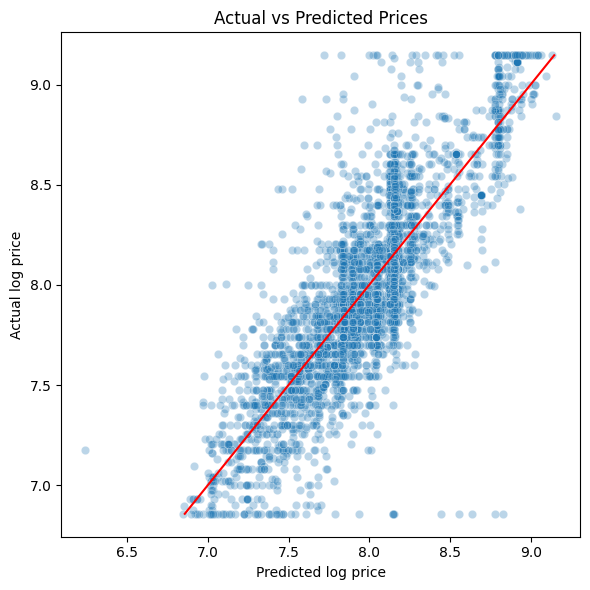

In [25]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_pred, y=y_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')
plt.xlabel("Predicted log price")
plt.ylabel("Actual log price")
plt.title("Actual vs Predicted Prices")
plt.tight_layout()
plt.savefig("../images/actual_vs_predicted.png", dpi=300)
plt.show()


The actual vs predicted plot shows a strong linear relationship, with most observations
lying close to the diagonal reference line. Prediction errors increase slightly for
higher-priced properties, which is expected in real estate data where luxury pricing
depends on factors not captured in the dataset.


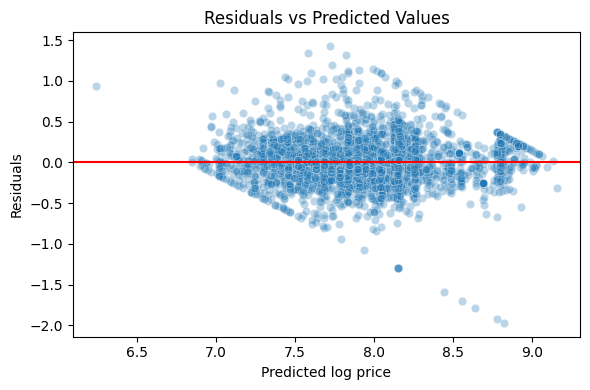

In [26]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red')
plt.xlabel("Predicted log price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.tight_layout()
plt.savefig("../images/residuals_vs_predicted.png", dpi=300)
plt.show()


Residuals are randomly distributed around zero with no strong systematic pattern.
A mild increase in variance is observed at higher predicted prices, indicating
slight heteroscedasticity, which is common in housing price models and does not
invalidate the regression results.


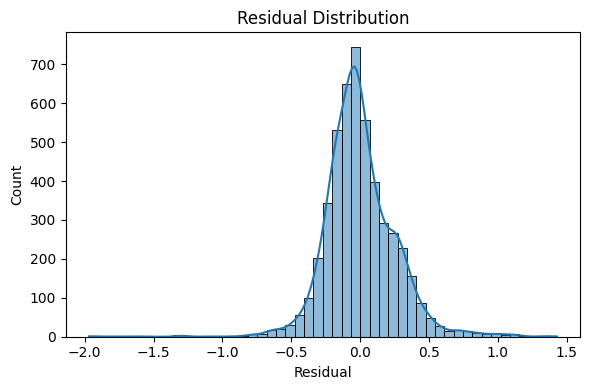

In [27]:
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Residual")
plt.title("Residual Distribution")
plt.tight_layout()
plt.savefig("../images/residuals_distribution.png", dpi=300)
plt.show()


The residual distribution is approximately normal and centered around zero,
indicating that prediction errors are largely unbiased. Minor skewness and
outliers remain, which is expected in real-world housing datasets.


## Regression Diagnostics and Model Validity


Diagnostic plots indicate that the linear regression model satisfies core assumptions
reasonably well. The relationship between predicted and actual prices is largely linear,
residuals are centered around zero, and no strong systematic patterns are observed.

While mild heteroscedasticity is present at higher price levels, this behavior is common
in housing price models and reflects increased uncertainty for luxury properties. Overall,
the model provides a reliable baseline for understanding price drivers in the Nigerian
housing market.
